Aluno: Gabriel Freitas Santos
Data: 24-03-2022
Disciplina: MEC2014 - HIML

Obtain features
    a. With AR models of each channel
        a. Ch2-Ch5, concatenating each AR model coefficient of each channel (model order = 30)
            a. X1 ---> 850 lines; 30*4=120 columns
    b. PCA of the matrix built in 4.a.a.
        a. X2 ---> 850 lines; << 120 columns after dimensionality reduction
    b. Scale all features individually in e.g. [-1,1]
    c. Visualize and compare X1, X2 (see code in Plotting multidimensional spaces)

0 - Inicializando Equipamento

In [5]:
import pandas as pd
import scipy.io as sio
import numpy as np
from os import getcwd
from os.path import join 
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from statsmodels.tsa import ar_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns


1 - Download Conjunto de Dados:
(https://github.com/helonayala/himl_read_data)

In [6]:
fname = join(getcwd(),'data3SS2009.mat')
mat_contents = sio.loadmat(fname)
dataset = mat_contents['dataset']
N, Chno, Nc = dataset.shape
y = mat_contents['labels'].reshape(Nc)
print(f'Amostras:{N}, Canais:{Chno}, Numero de Casos:{Nc}')

Amostras:8192, Canais:5, Numero de Casos:850


2 - Definição das variaveis de cada Canal

In [7]:
Ch1 = dataset[:,0,:] # célula de carga: força do shaker
Ch2 = dataset[:,1,:] # acelerômetro: base
Ch3 = dataset[:,2,:] # acelerômetro: 1o andar
Ch4 = dataset[:,3,:] # acelerômetro: 2o andar
Ch5 = dataset[:,4,:] # acelerômetro: 3o andar

3- Buscar pesos do modelo AR

In [8]:
FeatAR = []
na=30 #Model Order
for i in tqdm(range(Nc)):
    ARmodel2 = ar_model.AutoReg(Ch2[:,i],na).fit()
    ARmodel3 = ar_model.AutoReg(Ch3[:,i],na).fit()
    ARmodel4 = ar_model.AutoReg(Ch4[:,i],na).fit()
    ARmodel5 = ar_model.AutoReg(Ch5[:,i],na).fit()
    ARparams = np.concatenate([ARmodel2.params,ARmodel3.params,ARmodel4.params,ARmodel5.params])
    FeatAR.append(ARparams)
FeatAR=np.array(FeatAR)
FeatAR.shape # X1


  0%|          | 0/850 [00:00<?, ?it/s]

(850, 124)

4 - Aplicar PCA para redução de dimensionalidade

Número de Componentes que garante 90% da variancia explica é de 4. Total Variância explicada de 91.09%


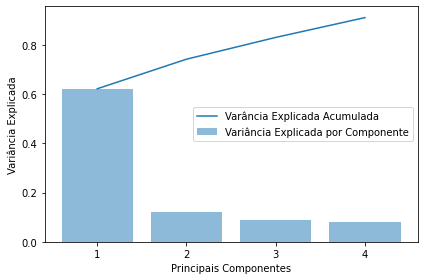

In [9]:
ln,cols = FeatAR.shape
for i in range(1,cols+1,1):
    pca = PCA(n_components=i)
    X2 = pca.fit_transform(FeatAR)
    exp_var_arr = pca.explained_variance_ratio_
    exp_var = sum(exp_var_arr)
    if exp_var>=0.9:
        break
    else:
        continue
print(f'Número de Componentes que garante 90% da variancia explica é de {i}. Total Variância explicada de {round(exp_var*100,2)}%')
plt.figure(facecolor='white')
plt.bar(range(1,len(exp_var_arr)+1,1),exp_var_arr, alpha=0.5, align='center', label='Variância Explicada por Componente')
plt.plot(range(1,len(exp_var_arr)+1,1),np.cumsum(exp_var_arr),label='Varância Explicada Acumulada')
plt.ylabel('Variância Explicada')
plt.xlabel('Principais Componentes')
plt.xticks(range(1,len(exp_var_arr)+1,1))
plt.legend()
plt.tight_layout()

5 -  Normalizar ("Scaler") entradas do modelo:

In [10]:
#Montar metodo de normalização
scaler = MinMaxScaler(feature_range=(-1,1))

indDam = y > 9 #False = "Não Danificado" | True = "Danificado"
dfARX1 = pd.concat([pd.DataFrame(scaler.fit_transform(FeatAR)),pd.DataFrame({'target':indDam})],axis=1) #Normalização e criação de DF para plot de X1
dfARX2 = pd.concat([pd.DataFrame(scaler.fit_transform(X2)),pd.DataFrame({'target':indDam})],axis=1)     #Normalização e criação de DF para plot de X2

6 - Plot Parallel (Plottin Multidimensional Spaces)

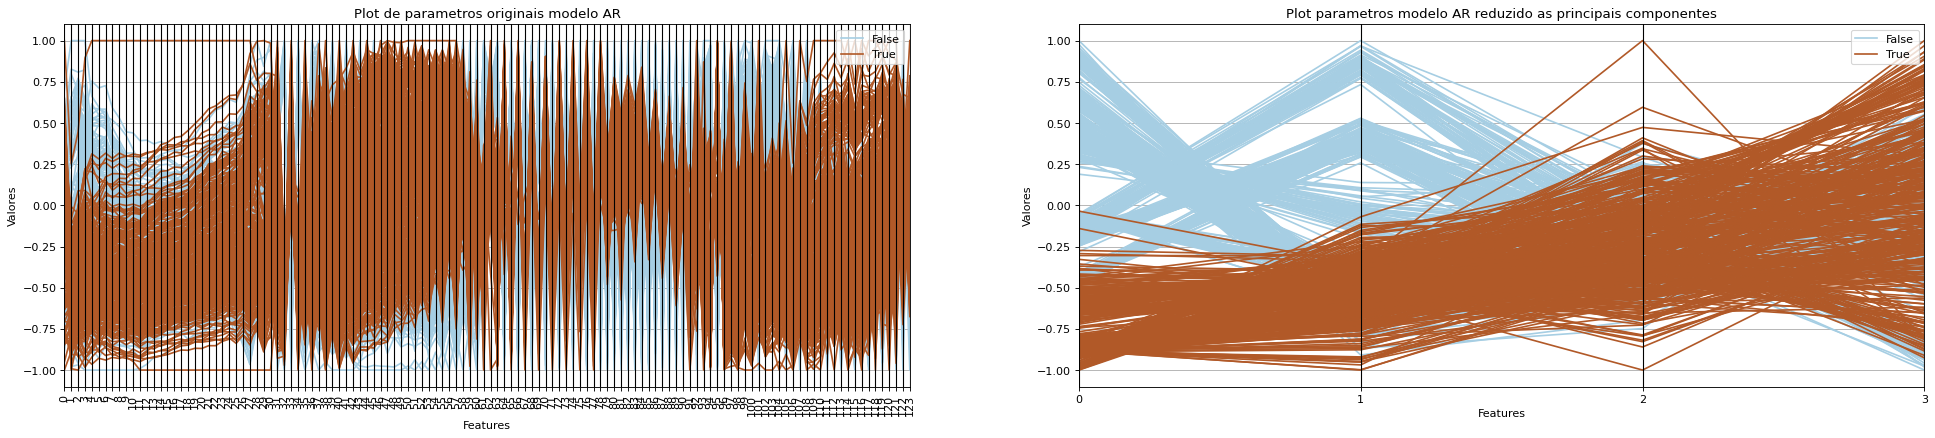

In [11]:
plt.figure(facecolor='white',figsize=(30, 6), dpi=80)
plt.subplot(121)
pd.plotting.parallel_coordinates(dfARX1,'target',colormap=plt.get_cmap('Paired'))
plt.ylabel('Valores')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.title('Plot de parametros originais modelo AR')
plt.subplot(122)
pd.plotting.parallel_coordinates(dfARX2,'target',colormap=plt.get_cmap('Paired'))
plt.ylabel('Valores')
plt.xlabel('Features')
plt.title('Plot parametros modelo AR reduzido as principais componentes')
plt.show()

7 - Comparação Plot parallel entre Danificados e Não Danificados

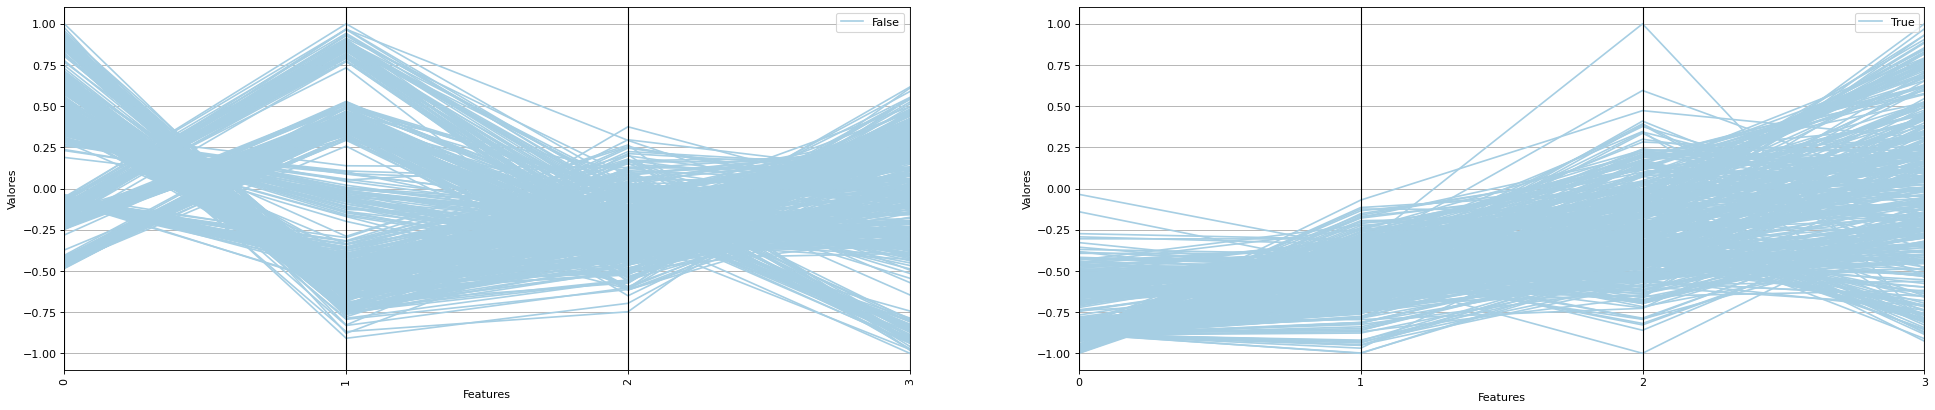

In [12]:
plt.figure(facecolor='white',figsize=(30, 6), dpi=80)
plt.subplot(121)
pd.plotting.parallel_coordinates(dfARX2[dfARX2['target']==0],'target',colormap=plt.get_cmap('Paired'))
plt.ylabel('Valores')
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.subplot(122)
pd.plotting.parallel_coordinates(dfARX2[dfARX2['target']==1],'target',colormap=plt.get_cmap('Paired'))
plt.ylabel('Valores')
plt.xlabel('Features')
plt.show()

8 - Treino do modelo linear softmax

In [13]:
# Separar Data set em conjuntos de treino e teste ()
train_X1, test_X1, train_X1_tg, test_X1_tg = train_test_split(dfARX1[dfARX1.columns[0:-1]], dfARX1.target, test_size=0.3, random_state=0)
train_X2, test_X2, train_X2_tg, test_X2_tg = train_test_split(dfARX2[dfARX2.columns[0:-1]], dfARX2.target, test_size=0.3, random_state=0)

# Regressão Softmax para X1
softmax_reg_X1 = LogisticRegression(multi_class='multinomial',solver='lbfgs',C=10)
softmax_reg_X1.fit(train_X1,train_X1_tg)
pred_X1 = softmax_reg_X1.predict(test_X1)
pred_proba_X1 = softmax_reg_X1.predict_proba(test_X1)

# Regressão Softmax para X2
softmax_reg_X2 = LogisticRegression(multi_class='multinomial',solver='lbfgs',C=10)
softmax_reg_X2.fit(train_X2,train_X2_tg)
pred_X2 = softmax_reg_X2.predict(test_X2)
pred_proba_X2 = softmax_reg_X2.predict_proba(test_X2)

9 - Plot e Comparação de Resultados

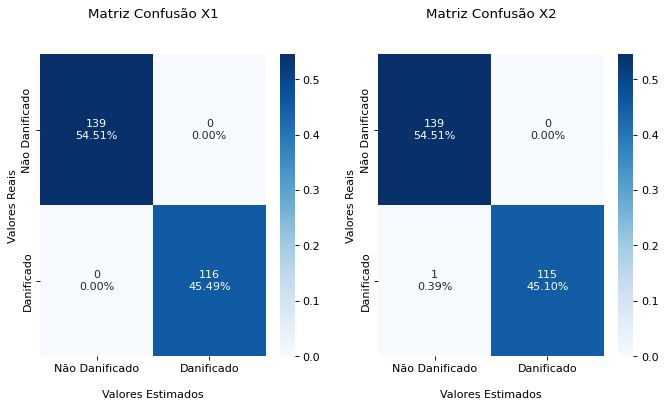

In [14]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts_x1 = ["{0:0.0f}".format(value) for value in
                confusion_matrix(test_X1_tg, pred_X1).flatten()]
group_counts_x2 = ["{0:0.0f}".format(value) for value in
                confusion_matrix(test_X2_tg, pred_X2).flatten()]                

group_percentages_x1 = ["{0:.2%}".format(value) for value in
                     confusion_matrix(test_X1_tg, pred_X1).flatten()/np.sum(confusion_matrix(test_X1_tg, pred_X1))]
group_percentages_x2 = ["{0:.2%}".format(value) for value in
                     confusion_matrix(test_X2_tg, pred_X2).flatten()/np.sum(confusion_matrix(test_X2_tg, pred_X2))]                     

labels_x1 = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts_x1,group_percentages_x1)]
labels_x2 = [f"{v2}\n{v3}" for v2, v3 in
          zip(group_counts_x2,group_percentages_x2)]          

labels_x1 = np.asarray(labels_x1).reshape(2,2)
labels_x2 = np.asarray(labels_x2).reshape(2,2)
plt.figure(facecolor='white',figsize=(10, 5), dpi=80)
plt.subplot(121)
ax1 = sns.heatmap(confusion_matrix(test_X1_tg, pred_X1)/len(test_X1_tg),annot=labels_x1,  cmap='Blues', fmt='')
ax1.set_title('Matriz Confusão X1\n\n')
ax1.set_xlabel('\nValores Estimados')
ax1.set_ylabel('Valores Reais')

## Ticket labels - List must be in alphabetical order
ax1.xaxis.set_ticklabels(['Não Danificado','Danificado'])
ax1.yaxis.set_ticklabels(['Não Danificado','Danificado'])

plt.subplot(122)
ax2 = sns.heatmap(confusion_matrix(test_X2_tg, pred_X2)/len(test_X2_tg), annot=labels_x2, cmap='Blues', fmt='')
ax2.set_title('Matriz Confusão X2\n\n')
ax2.set_xlabel('\nValores Estimados')
ax2.set_ylabel('Valores Reais')

## Ticket labels - List must be in alphabetical order
ax2.xaxis.set_ticklabels(['Não Danificado','Danificado'])
ax2.yaxis.set_ticklabels(['Não Danificado','Danificado'])
plt.show()

In [15]:
x1_accuracy = accuracy_score(test_X1_tg, pred_X1,normalize=False)
x2_accuracy = accuracy_score(test_X2_tg, pred_X2,normalize=False)
print(f"""\n\tA acurácia medida para o conjunto X2 é igual a {round(100*x2_accuracy/len(test_X2_tg),2)}% contra uma acurácia medida para o conjunto X1 de {100*x1_accuracy/len(test_X1_tg)}%,levando em consideração que
        o modelo aplicado em X2 é consideraval mais simples  que o aplicado em X1 ({len(exp_var_arr)} features contra {cols}), a perda de acurácia de apenas {round(100*(x1_accuracy-x2_accuracy)/len(test_X2_tg),2)}%
        justifica-se pela eficiência obtida com redução de {round(100*(1-len(exp_var_arr)/cols))}% das features.""")


	A acurácia medida para o conjunto X2 é igual a 99.61% contra uma acurácia medida para o conjunto X1 de 100.0%,levando em consideração que
        o modelo aplicado em X2 é consideraval mais simples  que o aplicado em X1 (4 features contra 124), a perda de acurácia de apenas 0.39%
        justifica-se pela eficiência obtida com redução de 97% das features
